In [1]:
#POOT Library
from ROOT import TMVA, TFile, TTree, TCut, TString
#DNN Library Pytorch
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Optimizer SWATS 
import swats
#numpy, pandas, matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from importlib import reload
import pandas as pd
import random
from array import array
#ML library
import pickle
import scikitplot as skplt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
#XGBoost Library
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython import display
import graphviz
#Cuda Library
from numba import cuda
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
from math import sqrt
import gc 
from scipy.stats import poisson
import multiprocessing

Welcome to JupyROOT 6.19/01


Cuda Functions for data normalization
1. Calculate sum of a vector

2. Calculate mean value

3. Calculate variance

Function use to do Guassian Normalization:
Mean:
$$\mu_{i}=\frac{\sum x_{i}\times w_{i}}{\sum w_{i}}$$
Variance:
$$\sigma_{i}=\frac{\sum (x_{i}-\mu_{i})^{2}\times w_{i}}{\frac{N-1}{N}\times\sum w_{i}}$$
Normalized input feature:
$$\bar{x_{i}}=\frac{x_{i}-\mu_{i}}{\sigma_{i}}$$

cuda function is in cuda_guass_normal/__iniit__.py
use pip install . or pip install cuda_guass_normal first
package information: https://pypi.org/project/cuda-guass-normal/

In [2]:
import cuda_guass_normal

Load signal and background files:

In [3]:
signalFile = TFile.Open("../sample-train-1016/tree_sig.root")
backgroundFile = TFile.Open("../sample-train-1016/tree_bkg.root")

signalTree = signalFile.Get("tree_NOMINAL")
backgroundTree = backgroundFile.Get("tree_NOMINAL")

signalNum = signalTree.GetEntries()
backgroundNum = backgroundTree.GetEntries()
print("signal events number before cut is: ", signalNum)
print("background events number before cut is: ", backgroundNum)

signal events number before cut is:  179655
background events number before cut is:  197061


Convert minitree into numpy and dataframe:

In [4]:
variable_names=["weight","MH","MET","MET_Sig","MET_Phi","MET_MM_DeltaPhi","PtDivM","Aux1_MM_DeltaEta","L1PtDivM","L2PtDivM","Aux1_Eta","nJets","Aux1_Pt","Aux1_MET_Mt"]

In [5]:
signalArray=signalTree.AsMatrix(variable_names)

backgroundArray=backgroundTree.AsMatrix(variable_names)
    
print(signalArray.shape)
print("signal yield before cut is: ",sum(signalArray[:,0]))
print("background yield before cut is:",sum(backgroundArray[:,0]))

signal_df=pd.DataFrame(data=signalArray,columns=variable_names)
background_df=pd.DataFrame(data=backgroundArray,columns=variable_names)
SigYield=sum(signalArray[:,0])
BkgYield=sum(backgroundArray[:,0])

(179655, 14)
signal yield before cut is:  5.614492716757147
background yield before cut is: 3570.225306781628


In [6]:
signal_df=signal_df[(signal_df["MH"]>110)&(signal_df["MH"]<130)]
background_df=background_df[(background_df["MH"]>110)&(background_df["MH"]<130)]
signal_df=signal_df.drop(columns=["MH"])
background_df=background_df.drop(columns=["MH"])

In [7]:
signal_df.describe()

weight            MET        MET_Sig        MET_Phi  \
count  170711.000000  170711.000000  170711.000000  170711.000000   
mean        0.000031      62.350677       0.278714      -0.012283   
std         0.000067      50.044541       0.187536       1.813959   
min        -0.000505       0.175037       0.000430      -3.141560   
25%         0.000015      29.876249       0.134456      -1.581351   
50%         0.000019      49.695511       0.239169      -0.021916   
75%         0.000027      79.445610       0.383908       1.557526   
max         0.001018    1170.733643       2.139764       3.141592   

       MET_MM_DeltaPhi         PtDivM  Aux1_MM_DeltaEta       L1PtDivM  \
count    170711.000000  170711.000000     170711.000000  170711.000000   
mean          2.579057       0.820946          1.035875     857.909237   
std           1.199691       0.626056          0.833888    1441.652295   
min           0.000005       0.000970          0.000013 -157669.558685   
25%           1.784587       0.400250          0.392047     624.715605   
50%           2.765099       0.666258          0.840271     804.903285   
75%           3.356534       1.059803          1.473593    1084.614729   
max           6.257823       9.311596          7.278125  134461.932632   

            L2PtDivM       Aux1_Eta          nJets        Aux1_Pt  \
count  170711.000000  170711.000000  170711.000000  170711.000000   
mean      447.889560      -0.004775       1.094927      61.345314   
std       495.630562       1.244736       1.479912      45.856026   
min   -100677.185042      -2.699960       0.000000      10.000070   
25%       310.874655      -0.972221       0.000000      31.054697   
50%       422.058885      -0.006046       1.000000      49.523869   
75%       538.970080       0.958362       2.000000      77.134937   
max     26619.461713       2.699681      12.000000    1112.783447   

         Aux1_MET_Mt  
count  170711.000000  
mean       58.125374  
std        34.531946  
min         0.000800  
25%        33.848408  
50%        58.741909  
75%        78.042604  
max      2282.288630

In [8]:
background_df.describe()

weight            MET        MET_Sig        MET_Phi  \
count  118494.000000  118494.000000  118494.000000  118494.000000   
mean        0.016688      51.454933       0.211360      -0.009087   
std         0.159816      51.870687       0.169673       1.810328   
min       -21.036720       0.057079       0.000337      -3.141582   
25%         0.000781      21.970514       0.088616      -1.580950   
50%         0.003040      38.535694       0.164339      -0.018549   
75%         0.006467      64.196913       0.286491       1.558314   
max        14.355469    3981.738770       4.355298       3.141566   

       MET_MM_DeltaPhi         PtDivM  Aux1_MM_DeltaEta       L1PtDivM  \
count    118494.000000  118494.000000     118494.000000  118494.000000   
mean          2.323306       0.759976          1.331762     765.365562   
std           1.375356       0.747248          1.040731    1368.271862   
min           0.000040       0.002553          0.000011 -147730.746916   
25%           1.163155       0.332310          0.509886     542.372919   
50%           2.371491       0.563720          1.097965     705.577074   
75%           3.288388       0.937028          1.918759     972.154604   
max           6.280144      20.921852          8.925655   89159.120335   

            L2PtDivM       Aux1_Eta          nJets        Aux1_Pt  \
count  118494.000000  118494.000000  118494.000000  118494.000000   
mean      395.193850       0.003381       1.449187      53.764941   
std       332.907213       1.331552       1.291273      54.160783   
min    -28145.736430      -2.699650       0.000000      10.001163   
25%       267.624026      -1.065027       0.000000      22.505257   
50%       373.032651       0.007559       1.000000      38.351761   
75%       482.060916       1.070347       2.000000      65.726534   
max     27793.688951       2.699860      12.000000    3986.699707   

         Aux1_MET_Mt  
count  118494.000000  
mean       56.533603  
std        51.349395  
min         0.000169  
25%        25.532475  
50%        49.921710  
75%        76.652840  
max      7968.436716

select events in HM/DF (region4) region $$m_{ll}<75$$ GeV and different flavor lepton pair:

In Guassian normalization, mean and variance are calculated using total signal+background event in HM/DF region:

In [9]:
dataNormal_pre=signal_df.append(background_df)
dataNormal_weight_df=dataNormal_pre["weight"]
dataNormal_df=dataNormal_pre.drop(columns=["weight"])
dataNormal_df.describe()

dataNormal=dataNormal_df.values
dataNormal_weight=dataNormal_weight_df.values

Add label to signal and background:

In [10]:
signal_df["label"]=1
background_df["label"]=0

signal_df.describe()

weight            MET        MET_Sig        MET_Phi  \
count  170711.000000  170711.000000  170711.000000  170711.000000   
mean        0.000031      62.350677       0.278714      -0.012283   
std         0.000067      50.044541       0.187536       1.813959   
min        -0.000505       0.175037       0.000430      -3.141560   
25%         0.000015      29.876249       0.134456      -1.581351   
50%         0.000019      49.695511       0.239169      -0.021916   
75%         0.000027      79.445610       0.383908       1.557526   
max         0.001018    1170.733643       2.139764       3.141592   

       MET_MM_DeltaPhi         PtDivM  Aux1_MM_DeltaEta       L1PtDivM  \
count    170711.000000  170711.000000     170711.000000  170711.000000   
mean          2.579057       0.820946          1.035875     857.909237   
std           1.199691       0.626056          0.833888    1441.652295   
min           0.000005       0.000970          0.000013 -157669.558685   
25%           1.784587       0.400250          0.392047     624.715605   
50%           2.765099       0.666258          0.840271     804.903285   
75%           3.356534       1.059803          1.473593    1084.614729   
max           6.257823       9.311596          7.278125  134461.932632   

            L2PtDivM       Aux1_Eta          nJets        Aux1_Pt  \
count  170711.000000  170711.000000  170711.000000  170711.000000   
mean      447.889560      -0.004775       1.094927      61.345314   
std       495.630562       1.244736       1.479912      45.856026   
min   -100677.185042      -2.699960       0.000000      10.000070   
25%       310.874655      -0.972221       0.000000      31.054697   
50%       422.058885      -0.006046       1.000000      49.523869   
75%       538.970080       0.958362       2.000000      77.134937   
max     26619.461713       2.699681      12.000000    1112.783447   

         Aux1_MET_Mt     label  
count  170711.000000  170711.0  
mean       58.125374       1.0  
std        34.531946       0.0  
min         0.000800       1.0  
25%        33.848408       1.0  
50%        58.741909       1.0  
75%        78.042604       1.0  
max      2282.288630       1.0

Split training and testing sub-sample. Test size=0.2

In [11]:
signal_df_train1,signal_df_test1=train_test_split(signal_df,test_size=0.2)
background_df_train1,background_df_test1=train_test_split(background_df,test_size=0.2)

Drop negative weight events in training and testing. Negative events will cause DNN trainning stop too early and loss oscillation in late epoches.

In [12]:
signal_df_train=signal_df_train1[signal_df_train1["weight"]>0]
signal_df_test=signal_df_test1[signal_df_test1["weight"]>0]
background_df_train=background_df_train1[background_df_train1["weight"]>0]
background_df_test=background_df_test1[background_df_test1["weight"]>0]

signal_df_train.describe()

weight            MET        MET_Sig        MET_Phi  \
count  1.307400e+05  130740.000000  130740.000000  130740.000000   
mean   3.369956e-05      61.262676       0.281616      -0.008075   
std    6.692294e-05      49.062780       0.188272       1.811811   
min    5.185152e-11       0.194922       0.000430      -3.141500   
25%    1.614331e-05      29.542381       0.136851      -1.574794   
50%    1.950691e-05      49.004837       0.242227      -0.013413   
75%    2.759420e-05      77.916542       0.387946       1.560806   
max    1.017800e-03    1026.447144       2.139764       3.141548   

       MET_MM_DeltaPhi         PtDivM  Aux1_MM_DeltaEta       L1PtDivM  \
count    130740.000000  130740.000000     130740.000000  130740.000000   
mean          2.587732       0.814373          1.036383     850.928214   
std           1.191848       0.620670          0.834703    1469.985960   
min           0.000005       0.000970          0.000013 -157669.558685   
25%           1.810379       0.397342          0.392295     622.752681   
50%           2.772437       0.660568          0.840828     801.175619   
75%           3.356078       1.051352          1.474661    1079.054578   
max           6.257823       9.232395          7.278125  134461.932632   

            L2PtDivM       Aux1_Eta          nJets        Aux1_Pt  \
count  130740.000000  130740.000000  130740.000000  130740.000000   
mean      447.667439      -0.006594       0.991288      61.186463   
std       424.447230       1.247984       1.366308      45.734902   
min    -58014.854701      -2.699960       0.000000      10.000070   
25%       311.090025      -0.978307       0.000000      31.111301   
50%       421.632735      -0.008249       1.000000      49.458059   
75%       537.932469       0.960980       1.000000      76.778015   
max     24386.669685       2.699681      12.000000     892.094849   

         Aux1_MET_Mt     label  
count  130740.000000  130740.0  
mean       57.691843       1.0  
std        33.536870       0.0  
min         0.001081       1.0  
25%        33.684807       1.0  
50%        58.471751       1.0  
75%        77.727869       1.0  
max      1344.169755       1.0

Scale total weight of signal= total weight of background

In [13]:
train_ratio=signal_df_train["weight"].sum()/background_df_train["weight"].sum()
test_ratio=signal_df_test["weight"].sum()/background_df_test["weight"].sum()
signal_df_train["weight"]=signal_df_train["weight"]/train_ratio
signal_df_test["weight"]=signal_df_test["weight"]/test_ratio

/home/shuzhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/shuzhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Create trainning and testing dataset:

In [14]:
data_df_train=signal_df_train.append(background_df_train)
data_df_test=signal_df_test.append(background_df_test)

data_df_train=shuffle(data_df_train)
data_df_test=shuffle(data_df_test)

data_train_label=data_df_train["label"]
data_train_weight=data_df_train["weight"]
data_train_data=data_df_train.drop(columns=["weight","label"])
data_test_label=data_df_test["label"]
data_test_weight=data_df_test["weight"]
data_test_data=data_df_test.drop(columns=["weight","label"])

In [15]:
data_train_data.describe()

MET        MET_Sig        MET_Phi  MET_MM_DeltaPhi  \
count  216426.000000  216426.000000  216426.000000    216426.000000   
mean       57.803087       0.252937      -0.006213         2.478378   
std        51.038165       0.184235       1.810691         1.276924   
min         0.057079       0.000337      -3.141569         0.000005   
25%        26.439453       0.112645      -1.573202         1.511587   
50%        45.045883       0.208252      -0.012360         2.646466   
75%        73.292789       0.350869       1.561925         3.333129   
max      3981.738770       4.355298       3.141566         6.280144   

              PtDivM  Aux1_MM_DeltaEta       L1PtDivM       L2PtDivM  \
count  216426.000000     216426.000000  216426.000000  216426.000000   
mean        0.799378          1.148189     817.583490     427.554818   
std         0.681121          0.927938    1441.367722     389.152083   
min         0.000970          0.000011 -157669.558685  -58014.854701   
25%         0.371991          0.431159     589.709199     292.274214   
50%         0.626754          0.927310     766.432375     401.666844   
75%         1.017478          1.636668    1045.035124     517.154834   
max        20.921852          8.925655  134461.932632   24386.669685   

            Aux1_Eta          nJets        Aux1_Pt    Aux1_MET_Mt  
count  216426.000000  216426.000000  216426.000000  216426.000000  
mean       -0.003340       1.202702      58.443244      57.412598  
std         1.279900       1.370053      49.916706      42.567300  
min        -2.699960       0.000000      10.000070       0.000330  
25%        -1.009604       0.000000      27.241066      30.158797  
50%        -0.004158       1.000000      45.323917      55.635450  
75%         0.998935       2.000000      73.163210      77.538349  
max         2.699860      12.000000    3986.699707    7968.436716

Convert dataframe into numpy array:

In [16]:
dataTrainSample=data_train_data.values
dataTestSample=data_test_data.values
dataTrainWeight=data_train_weight.values
dataTestWeight=data_test_weight.values
dataTrainLabel=data_train_label.values
dataTestLabel=data_test_label.values

Prepare signal and background array for performance checking:

In [17]:
signal_df_weight=signal_df["weight"]
signal_df_data=signal_df.drop(columns=["weight","label"])
background_df_weight=background_df["weight"]
background_df_data=background_df.drop(columns=["weight","label"])
signalSample=signal_df_data.values
backgroundSample=background_df_data.values
signalWeight=signal_df_weight.values
backgroundWeight=background_df_weight.values

Normalize input featrues:

In [18]:
reload(cuda_guass_normal)

dataTrainSample1=cuda_guass_normal.guass_normal(dataTrainSample,dataNormal,dataNormal_weight)
dataTestSample1=cuda_guass_normal.guass_normal(dataTestSample,dataNormal,dataNormal_weight)

signalSample1=cuda_guass_normal.guass_normal(signalSample,dataNormal,dataNormal_weight)
backgroundSample1=cuda_guass_normal.guass_normal(backgroundSample,dataNormal,dataNormal_weight)

(array([2.16083e+05, 3.25000e+02, 1.60000e+01, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-0.16668019,  1.1745004 ,  2.51568099,  3.85686158,  5.19804217,
         6.53922276,  7.88040335,  9.22158394, 10.56276453, 11.90394512,
        13.24512571]),
 <a list of 10 Patch objects>)

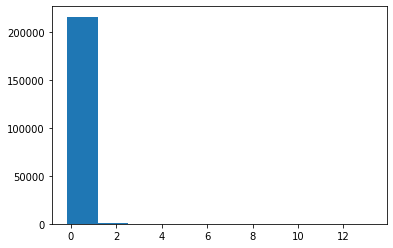

In [19]:
plt.hist(dataTrainSample1[:,10])

(array([2.1639e+05, 1.8000e+01, 1.1000e+01, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([1.02995928e-09, 1.43554688e+00, 2.87109375e+00, 4.30664063e+00,
        5.74218751e+00, 7.17773438e+00, 8.61328126e+00, 1.00488281e+01,
        1.14843750e+01, 1.29199219e+01, 1.43554688e+01]),
 <a list of 10 Patch objects>)

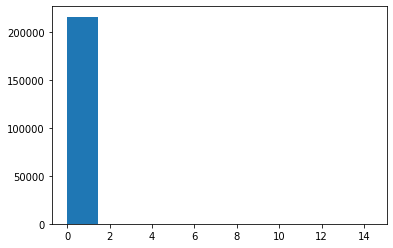

In [20]:
plt.hist(dataTrainWeight)

Create dataLoader for trainning and load to GPU. If no GPU avaliable, use "torch.device("cpu")
Batch size in trainning: 5000. Use large batch size due to signal and background event num is highly unbalanced.

In [21]:
num_cpu=multiprocessing.cpu_count()
print(num_cpu)

16


In [22]:
drv.init()
device = torch.device("cuda")
y_tensor = torch.tensor(dataTrainLabel, dtype=torch.float)#.to(device)
WeightTensor=torch.tensor((dataTrainWeight), dtype=torch.float)#.to(device)
dataTrainTensor=torch.tensor(dataTrainSample1, dtype=torch.float)#.to(device)
dataTestTensor=torch.tensor(dataTestSample1,dtype=torch.float)#.to(device)
TrainDataset = TensorDataset( WeightTensor, dataTrainTensor, y_tensor)
TrainLoader = DataLoader(TrainDataset, batch_size=1000, shuffle=False,num_workers=num_cpu-1,pin_memory=True)
TestWeightTensor=torch.tensor(dataTestWeight,dtype=torch.float)#.to(device)
test_y_tensor=torch.tensor(dataTestLabel, dtype=torch.float)#.to(device)
TestDataset = TensorDataset((TestWeightTensor), dataTestTensor, test_y_tensor)
TestLoader = DataLoader(TestDataset, batch_size=1000, shuffle=False,num_workers=num_cpu-1,pin_memory=True)

Build model: 21 input variables, 3 hidden layer, 100 nodes per layer, 1 dropout=0.2

Mish: a new Non-Monotonic Neural Activation Function. Better performance and stablity than ReLU. Refernce: https://arxiv.org/pdf/1908.08681.pdf

In [23]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x *( torch.tanh(F.softplus(x)))

In [24]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.utils.weight_norm(nn.Linear(12, 80),name='weight')
        self.relu1 = Mish()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.utils.weight_norm(nn.Linear(80, 80),name='weight')
        self.relu2 = Mish()
        self.fc3 = nn.utils.weight_norm(nn.Linear(80, 80),name='weight')
        self.relu3 = Mish()
        self.fc4 = nn.utils.weight_norm(nn.Linear(80, 80),name='weight')
        self.relu4 = Mish()
        self.out = nn.Linear(80, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.relu2(a2)
        a3 = self.fc2(h2)
        h3 = self.relu3(a3)
        a4 = self.fc2(h3)
        h4 = self.relu4(a4)
        a5 = self.out(h4)
        y = self.out_act(a5)
        return y

Init weights in each layer use xavier normal:

In [25]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

trainning part:

In [26]:
def train(model, device, train_loader, loss_function, optimizer, epoch):
    model.train()
    average_loss=0
    batch_n=0
    for batch_idx, (sample_weight, data, target) in enumerate(train_loader):
        batch_n=batch_n+1
        data, target,sample_weight = data.to(device), target.to(device), sample_weight.to(device)
        
        optimizer.zero_grad()
        data=data.squeeze()
        output = model(data)
        loss_function.weight = sample_weight/sample_weight.mean()
        #my_weight=sample_weight/sample_weight.mean()
        output=output.reshape(-1)
        loss = loss_function(output, target)
        #loss = custom_loss(output, target,my_weight)
        loss.backward()
        average_loss=average_loss+loss.item()
        optimizer.step()
        torch.cuda.empty_cache()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    print("Average loss in epoch ",epoch," is: ",average_loss/batch_n)
    return(average_loss/batch_n)

evaluation part:

In [27]:
def eval_train(model,device,input_loader,loss_function):
    average_loss=0
    batch_n=0
    model.eval()
    with torch.no_grad():
        for batch_idx, (sample_weight, data, target) in enumerate(input_loader):
            batch_n=batch_n+1
            data, target,sample_weight = data.to(device), target.to(device), sample_weight.to(device)
            output = model(data)
            output=output.reshape(-1)
            loss_function.weight = sample_weight/sample_weight.mean()
            loss = loss_function(output, target)
            average_loss=average_loss+loss.item()
    return(average_loss/batch_n)

Send model to GPU and inital weights

In [28]:
model = Net().to(device)
model.apply(init_weights)

Net(
  (fc1): Linear(in_features=12, out_features=80, bias=True)
  (relu1): Mish()
  (dout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=80, out_features=80, bias=True)
  (relu2): Mish()
  (fc3): Linear(in_features=80, out_features=80, bias=True)
  (relu3): Mish()
  (fc4): Linear(in_features=80, out_features=80, bias=True)
  (relu4): Mish()
  (out): Linear(in_features=80, out_features=1, bias=True)
  (out_act): Sigmoid()
)

Loss: Binary Cross Entropy:

In [29]:
loss_fn =nn.BCELoss().cuda()
#loss_fn=custom_loss()
#optimizer = optim.Adam(model.parameters())
optimizer=swats.SWATS(model.parameters())
#optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.6)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

Trainning model. Evaluate model after each epoches. Stop trainning if evaluate loss doesn't decrease for 4 epoches:

In [30]:
lowest_loss=9999
counter=0
best_epoch=0
pat=4
loss_np=np.zeros((300,1))
loss_test_np=np.zeros((300,1))
for epoch in range(1, 300):
        loss_epoch=train(model, device, TrainLoader,loss_fn, optimizer, epoch)
        loss_test_epoch=eval_train(model, device, TestLoader,loss_fn)
        loss_np[epoch-1]=loss_epoch
        loss_test_np[epoch-1]=loss_test_epoch
        if(loss_test_epoch<lowest_loss):
            counter=0
            best_epoch=epoch
            lowest_loss=loss_test_epoch
        else:
            counter=counter+1
        if(counter==pat):
            print("Stopping, best epoch is: ",best_epoch," lowest loss is: ",lowest_loss)
            break
        

Train Epoch: 1 [0/216426 (0%)]	Loss: 0.693980
Train Epoch: 1 [10000/216426 (5%)]	Loss: 0.691048
Train Epoch: 1 [20000/216426 (9%)]	Loss: 0.688977
Train Epoch: 1 [30000/216426 (14%)]	Loss: 0.645479
Train Epoch: 1 [40000/216426 (18%)]	Loss: 0.643343
Train Epoch: 1 [50000/216426 (23%)]	Loss: 0.670961
Train Epoch: 1 [60000/216426 (28%)]	Loss: 0.651139
Train Epoch: 1 [70000/216426 (32%)]	Loss: 0.668274
Train Epoch: 1 [80000/216426 (37%)]	Loss: 0.627904
Train Epoch: 1 [90000/216426 (41%)]	Loss: 0.700686
Train Epoch: 1 [100000/216426 (46%)]	Loss: 0.648076
Train Epoch: 1 [110000/216426 (51%)]	Loss: 0.652980
Train Epoch: 1 [120000/216426 (55%)]	Loss: 0.631873
Train Epoch: 1 [130000/216426 (60%)]	Loss: 0.581328
Train Epoch: 1 [140000/216426 (65%)]	Loss: 0.619751
Train Epoch: 1 [150000/216426 (69%)]	Loss: 0.658677
Train Epoch: 1 [160000/216426 (74%)]	Loss: 0.619912
Train Epoch: 1 [170000/216426 (78%)]	Loss: 0.627340
Train Epoch: 1 [180000/216426 (83%)]	Loss: 0.632246
Train Epoch: 1 [190000/216426

Train Epoch: 8 [0/216426 (0%)]	Loss: 0.548203
Train Epoch: 8 [10000/216426 (5%)]	Loss: 0.630961
Train Epoch: 8 [20000/216426 (9%)]	Loss: 0.615616
Train Epoch: 8 [30000/216426 (14%)]	Loss: 0.648103
Train Epoch: 8 [40000/216426 (18%)]	Loss: 0.633029
Train Epoch: 8 [50000/216426 (23%)]	Loss: 0.597737
Train Epoch: 8 [60000/216426 (28%)]	Loss: 0.611146
Train Epoch: 8 [70000/216426 (32%)]	Loss: 0.609351
Train Epoch: 8 [80000/216426 (37%)]	Loss: 0.552196
Train Epoch: 8 [90000/216426 (41%)]	Loss: 0.612102
Train Epoch: 8 [100000/216426 (46%)]	Loss: 0.657080
Train Epoch: 8 [110000/216426 (51%)]	Loss: 0.634785
Train Epoch: 8 [120000/216426 (55%)]	Loss: 0.551566
Train Epoch: 8 [130000/216426 (60%)]	Loss: 0.525336
Train Epoch: 8 [140000/216426 (65%)]	Loss: 0.596098
Train Epoch: 8 [150000/216426 (69%)]	Loss: 0.594703
Train Epoch: 8 [160000/216426 (74%)]	Loss: 0.612083
Train Epoch: 8 [170000/216426 (78%)]	Loss: 0.535435
Train Epoch: 8 [180000/216426 (83%)]	Loss: 0.599726
Train Epoch: 8 [190000/216426

Train Epoch: 14 [200000/216426 (92%)]	Loss: 0.546493
Train Epoch: 14 [210000/216426 (97%)]	Loss: 0.664431
Average loss in epoch  14  is:  0.5653594090916594
Train Epoch: 15 [0/216426 (0%)]	Loss: 0.531689
Train Epoch: 15 [10000/216426 (5%)]	Loss: 0.599486
Train Epoch: 15 [20000/216426 (9%)]	Loss: 0.583936
Train Epoch: 15 [30000/216426 (14%)]	Loss: 0.654925
Train Epoch: 15 [40000/216426 (18%)]	Loss: 0.610530
Train Epoch: 15 [50000/216426 (23%)]	Loss: 0.588343
Train Epoch: 15 [60000/216426 (28%)]	Loss: 0.592669
Train Epoch: 15 [70000/216426 (32%)]	Loss: 0.647351
Train Epoch: 15 [80000/216426 (37%)]	Loss: 0.531563
Train Epoch: 15 [90000/216426 (41%)]	Loss: 0.576665
Train Epoch: 15 [100000/216426 (46%)]	Loss: 0.671492
Train Epoch: 15 [110000/216426 (51%)]	Loss: 0.610148
Train Epoch: 15 [120000/216426 (55%)]	Loss: 0.528343
Train Epoch: 15 [130000/216426 (60%)]	Loss: 0.517667
Train Epoch: 15 [140000/216426 (65%)]	Loss: 0.539985
Train Epoch: 15 [150000/216426 (69%)]	Loss: 0.554354
Train Epoch:

Train Epoch: 21 [200000/216426 (92%)]	Loss: 0.569632
Train Epoch: 21 [210000/216426 (97%)]	Loss: 0.631214
Average loss in epoch  21  is:  0.5570314195573605
Train Epoch: 22 [0/216426 (0%)]	Loss: 0.516990
Train Epoch: 22 [10000/216426 (5%)]	Loss: 0.616690
Train Epoch: 22 [20000/216426 (9%)]	Loss: 0.594747
Train Epoch: 22 [30000/216426 (14%)]	Loss: 0.638089
Train Epoch: 22 [40000/216426 (18%)]	Loss: 0.566437
Train Epoch: 22 [50000/216426 (23%)]	Loss: 0.592508
Train Epoch: 22 [60000/216426 (28%)]	Loss: 0.585681
Train Epoch: 22 [70000/216426 (32%)]	Loss: 0.606476
Train Epoch: 22 [80000/216426 (37%)]	Loss: 0.512957
Train Epoch: 22 [90000/216426 (41%)]	Loss: 0.588061
Train Epoch: 22 [100000/216426 (46%)]	Loss: 0.673182
Train Epoch: 22 [110000/216426 (51%)]	Loss: 0.607454
Train Epoch: 22 [120000/216426 (55%)]	Loss: 0.513446
Train Epoch: 22 [130000/216426 (60%)]	Loss: 0.490560
Train Epoch: 22 [140000/216426 (65%)]	Loss: 0.530479
Train Epoch: 22 [150000/216426 (69%)]	Loss: 0.562463
Train Epoch:

Train Epoch: 28 [200000/216426 (92%)]	Loss: 0.559282
Train Epoch: 28 [210000/216426 (97%)]	Loss: 0.611864
Average loss in epoch  28  is:  0.5534544591255451
Train Epoch: 29 [0/216426 (0%)]	Loss: 0.522854
Train Epoch: 29 [10000/216426 (5%)]	Loss: 0.610384
Train Epoch: 29 [20000/216426 (9%)]	Loss: 0.584954
Train Epoch: 29 [30000/216426 (14%)]	Loss: 0.658815
Train Epoch: 29 [40000/216426 (18%)]	Loss: 0.567706
Train Epoch: 29 [50000/216426 (23%)]	Loss: 0.584204
Train Epoch: 29 [60000/216426 (28%)]	Loss: 0.605496
Train Epoch: 29 [70000/216426 (32%)]	Loss: 0.622663
Train Epoch: 29 [80000/216426 (37%)]	Loss: 0.507219
Train Epoch: 29 [90000/216426 (41%)]	Loss: 0.586418
Train Epoch: 29 [100000/216426 (46%)]	Loss: 0.662787
Train Epoch: 29 [110000/216426 (51%)]	Loss: 0.586985
Train Epoch: 29 [120000/216426 (55%)]	Loss: 0.527958
Train Epoch: 29 [130000/216426 (60%)]	Loss: 0.458447
Train Epoch: 29 [140000/216426 (65%)]	Loss: 0.513234
Train Epoch: 29 [150000/216426 (69%)]	Loss: 0.536027
Train Epoch:

Train Epoch: 35 [200000/216426 (92%)]	Loss: 0.560872
Train Epoch: 35 [210000/216426 (97%)]	Loss: 0.620063
Average loss in epoch  35  is:  0.5490521726795056
Train Epoch: 36 [0/216426 (0%)]	Loss: 0.528333
Train Epoch: 36 [10000/216426 (5%)]	Loss: 0.595030
Train Epoch: 36 [20000/216426 (9%)]	Loss: 0.566289
Train Epoch: 36 [30000/216426 (14%)]	Loss: 0.626850
Train Epoch: 36 [40000/216426 (18%)]	Loss: 0.583176
Train Epoch: 36 [50000/216426 (23%)]	Loss: 0.574969
Train Epoch: 36 [60000/216426 (28%)]	Loss: 0.589382
Train Epoch: 36 [70000/216426 (32%)]	Loss: 0.600442
Train Epoch: 36 [80000/216426 (37%)]	Loss: 0.497197
Train Epoch: 36 [90000/216426 (41%)]	Loss: 0.566411
Train Epoch: 36 [100000/216426 (46%)]	Loss: 0.642638
Train Epoch: 36 [110000/216426 (51%)]	Loss: 0.559120
Train Epoch: 36 [120000/216426 (55%)]	Loss: 0.518154
Train Epoch: 36 [130000/216426 (60%)]	Loss: 0.457622
Train Epoch: 36 [140000/216426 (65%)]	Loss: 0.502260
Train Epoch: 36 [150000/216426 (69%)]	Loss: 0.561035
Train Epoch:

Train Epoch: 42 [200000/216426 (92%)]	Loss: 0.548740
Train Epoch: 42 [210000/216426 (97%)]	Loss: 0.634001
Average loss in epoch  42  is:  0.5472761098690296
Train Epoch: 43 [0/216426 (0%)]	Loss: 0.523871
Train Epoch: 43 [10000/216426 (5%)]	Loss: 0.598330
Train Epoch: 43 [20000/216426 (9%)]	Loss: 0.555759
Train Epoch: 43 [30000/216426 (14%)]	Loss: 0.621102
Train Epoch: 43 [40000/216426 (18%)]	Loss: 0.529350
Train Epoch: 43 [50000/216426 (23%)]	Loss: 0.587807
Train Epoch: 43 [60000/216426 (28%)]	Loss: 0.588989
Train Epoch: 43 [70000/216426 (32%)]	Loss: 0.591197
Train Epoch: 43 [80000/216426 (37%)]	Loss: 0.505611
Train Epoch: 43 [90000/216426 (41%)]	Loss: 0.558784
Train Epoch: 43 [100000/216426 (46%)]	Loss: 0.635039
Train Epoch: 43 [110000/216426 (51%)]	Loss: 0.567720
Train Epoch: 43 [120000/216426 (55%)]	Loss: 0.520562
Train Epoch: 43 [130000/216426 (60%)]	Loss: 0.458391
Train Epoch: 43 [140000/216426 (65%)]	Loss: 0.500206
Train Epoch: 43 [150000/216426 (69%)]	Loss: 0.553712
Train Epoch:

Create learning curve for both trainning and evaluation proceess:

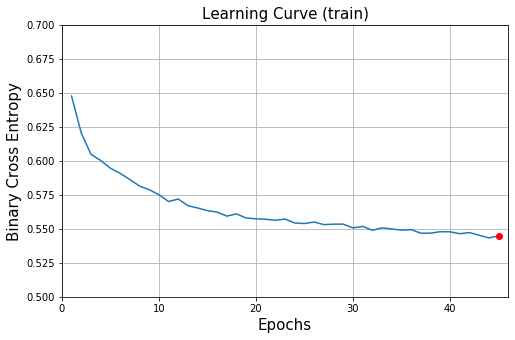

In [31]:
loss_train=loss_np[:best_epoch+3,0]
train_step=range(1,best_epoch+4)
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylabel('Binary Cross Entropy',fontsize=15)
ax.set_xlabel('Epochs',fontsize=15)
ax.set_title('Learning Curve (train)',fontsize=15)
ax.grid()
x = train_step
y = loss_train
l = ax.plot(x, y)
dot, = ax.plot([], [], 'ro')
def init():
    ax.set_xlim(0,best_epoch+4)
    ax.set_ylim(0.5,0.7)
    return l

def gen_dot():
    for i in range(1,best_epoch+4):
        newdot = [x[i-1], y[i-1]]
        yield newdot

def update_dot(newd):
    dot.set_data(newd[0], newd[1])
    return dot,

ani = animation.FuncAnimation(fig, update_dot, frames = gen_dot, interval = 100, init_func=init)
ani.save('../figure/1011-nomt/loss-3l.gif', writer='imagemagick', fps=30)
plt.show()

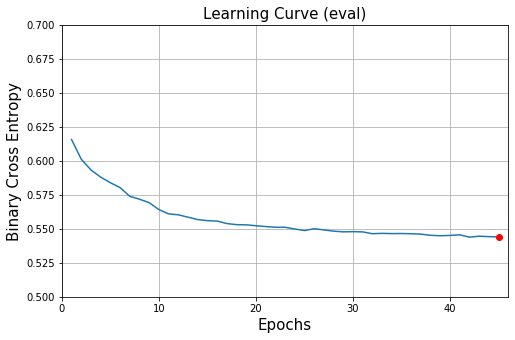

In [32]:
loss_train=loss_test_np[:best_epoch+3,0]
train_step=range(1,best_epoch+4)
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylabel('Binary Cross Entropy',fontsize=15)
ax.set_xlabel('Epochs',fontsize=15)
ax.set_title('Learning Curve (eval)',fontsize=15)
ax.grid()
x = train_step
y = loss_train
l = ax.plot(x, y)
dot, = ax.plot([], [], 'ro')
def init():
    ax.set_xlim(0,best_epoch+4)
    ax.set_ylim(0.5,0.7)
    return l

def gen_dot():
    for i in range(1,best_epoch+4):
        newdot = [x[i-1], y[i-1]]
        yield newdot

def update_dot(newd):
    dot.set_data(newd[0], newd[1])
    return dot,

ani = animation.FuncAnimation(fig, update_dot, frames = gen_dot, interval = 100, init_func=init)
ani.save('../figure/1011-nomt/loss-3l-test.gif', writer='imagemagick', fps=30)
plt.show()

Free GPU memory:

In [33]:
del TrainLoader
torch.cuda.empty_cache()
del TrainDataset
torch.cuda.empty_cache()
#del dataTrainTensor
#torch.cuda.empty_cache()
del WeightTensor
torch.cuda.empty_cache()

Apply DNN model function:

In [34]:
def eval_pytorch(model,device,input_loader):
    output_numpy=[1]
    model.eval()
    with torch.no_grad():
        for batch_idx, (data1) in enumerate(input_loader):
            score=model(data1)
            del data1
            score_np=score.data.cpu().numpy()
            output_numpy=np.vstack((output_numpy,score_np))
            torch.cuda.empty_cache()
    return(output_numpy)

Test DNN model on signal and background dataset:

[0.94877809 0.84560186 0.73034024 ... 0.5503673  0.43373874 0.5288111 ]
170711


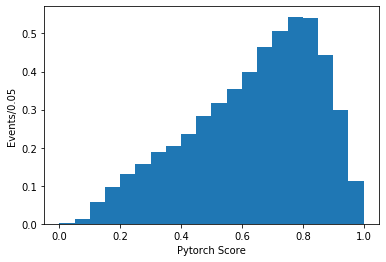

In [35]:
signalTensor = torch.tensor(signalSample1, dtype=torch.float, device=device)
signalLoader=DataLoader(signalTensor,batch_size=10000, shuffle=False)

sigScore = eval_pytorch(model,device,signalLoader)
sigScore=sigScore[1:,0]
print(sigScore)
print(len(sigScore))
plt.hist(sigScore,bins=20,weights=signalWeight)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/1011-nomt/NN-3l-sig.pdf', format='pdf', dpi=500)
plt.show()

[0.21948776 0.13701268 0.23044778 ... 0.20312355 0.32334843 0.48862895]
118494


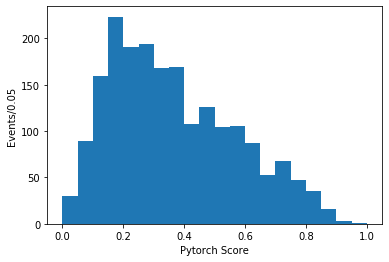

In [36]:
bakTensor= torch.tensor(backgroundSample1, dtype=torch.float,device=device)
backgroundLoader=DataLoader(bakTensor,batch_size=10000, shuffle=False)
bakScore = eval_pytorch(model,device,backgroundLoader)

bakScore=bakScore[1:,0]
print(bakScore)
print(len(bakScore))

plt.hist(bakScore,bins=20,weights=backgroundWeight)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/1011-nomt/NN-3l-bkg.pdf', format='pdf', dpi=500)
plt.show()

Create trainning and testing ROC curve:

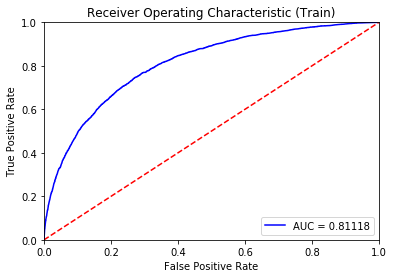

In [37]:
dataTrainTensor= torch.tensor(dataTrainSample1, dtype=torch.float,device=device)
dataTrainLoader=DataLoader(dataTrainTensor,batch_size=10000, shuffle=False)
TrainScore = eval_pytorch(model,device,dataTrainLoader)
TrainScore=TrainScore[1:,0]

fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,TrainScore,sample_weight=dataTrainWeight)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic (Train)')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/1011-nomt/roc-3l-train-NN.pdf', format='pdf', dpi=500)
plt.show()

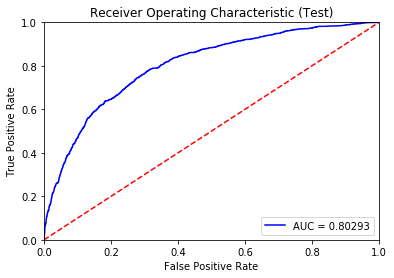

In [38]:
dataTestTensor= torch.tensor(dataTestSample1, dtype=torch.float,device=device)
dataTestLoader=DataLoader(dataTestTensor,batch_size=10000, shuffle=False)
TestScore = eval_pytorch(model,device,dataTestLoader)
TestScore=TestScore[1:,0]

fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,TestScore,sample_weight=dataTestWeight)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic (Test)')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/1011-nomt/roc-3l-test-NN.pdf', format='pdf', dpi=500)
plt.show()

Save DNN model:

In [ ]:
torch.save(model.state_dict(),'../NN_model/3l-pytorch-1011.pt')

Cuda funciton used to calculate yields with different DNN cut:

In [39]:
reload(cuda_guass_normal)

<module 'cuda_guass_normal' from '/home/shuzhou/anaconda3/lib/python3.7/site-packages/cuda_guass_normal/__init__.py'>

Scan Limits and significance use different DNN cut:

In [ ]:
def cal_limit(bkg,sig):
    p=1.0
    num=int(bkg)+1
    mu=0
    while(p>0.05):
        p=poisson.cdf(num, bkg+mu*sig)
        mu=mu+0.01
    return(mu)

limit=np.zeros((31,1))
x=np.zeros((31,1))
sig=np.zeros((31,1))
k=0
for i in np.arange(0.5,0.8,0.01):
    resB=cuda_guass_normal.cuda_cut(bakScore,backgroundWeight,i)
    resS=cuda_guass_normal.cuda_cut(sigScore,signalWeight,i)
    x[k]=i
    limit[k]=cal_limit(resB,resS)
    sig[k]=resS/sqrt(resB)
    k=k+1

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(8,6))
plt.plot(x,limit)
plt.xlabel("DNN Cut")
plt.ylabel("95% CL Upper Limit")
plt.title("Upper Limits in HM/SF Region")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/1011-nomt/Limits-3l.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(8,6))
plt.plot(x,sig)
plt.xlabel("DNN Cut")
plt.ylabel("S/sqrt(B)")
plt.title("Significance")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/1011-nomt/Sig-3l.pdf', format='pdf', dpi=500)
plt.show()

In [40]:
i=0.1
eff=(0.8,0.7,0.6,0.5,0.4,0.3)
j=0
k=0
t=0
min_diff=100
print(eff)
for i in np.arange(0,1,0.001):
    if(j>=6):
        break
    resS=cuda_guass_normal.cuda_cut(sigScore,signalWeight,i)
    ratio=resS/SigYield
    if(abs(ratio-eff[j])<0.1):
        t=1
        if(k==0):
            min_diff=100
        if(abs(ratio-eff[j])<min_diff):
            min_diff=abs(ratio-eff[j])
            BDT_cut=i
        k=k+1
           
    if(abs(ratio-eff[j])>0.05):
        if(t==1):
            j=j+1
            k=0
            t=0
            resB=cuda_guass_normal.cuda_cut(bakScore,backgroundWeight,BDT_cut)
            resS=cuda_guass_normal.cuda_cut(sigScore,signalWeight,BDT_cut)
            SBratio=resS/resB
            Sig=resS/sqrt(resB)
            print("If cut NN at ",BDT_cut, "signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
              " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio," Significance is: ",Sig)

(0.8, 0.7, 0.6, 0.5, 0.4, 0.3)
If cut NN at  0.249 signal yield is: [5.05179163]  Eff is: [0.89977704]  background yield is: [1287.26436294]  Eff is:  [0.3605555]  S/B ratio is:  [0.00392444]  Significance is:  [0.14080289]
If cut NN at  0.402 signal yield is: [4.49113011]  Eff is: [0.79991735]  background yield is: [748.992508]  Eff is:  [0.20978858]  S/B ratio is:  [0.00599623]  Significance is:  [0.16410314]
If cut NN at  0.509 signal yield is: [3.92255787]  Eff is: [0.69864867]  background yield is: [505.00124674]  Eff is:  [0.141448]  S/B ratio is:  [0.00776742]  Significance is:  [0.17455132]
If cut NN at  0.593 signal yield is: [3.36310959]  Eff is: [0.59900507]  background yield is: [325.90505475]  Eff is:  [0.09128417]  S/B ratio is:  [0.01031929]  Significance is:  [0.18629254]
If cut NN at  0.662 signal yield is: [2.80231869]  Eff is: [0.49912233]  background yield is: [200.19521607]  Eff is:  [0.05607355]  S/B ratio is:  [0.01399793]  Significance is:  [0.19805722]
If cut N

In [ ]:
resB=cuda_guass_normal.cuda_cut(bakScore,backgroundWeight,0.75)
resS=cuda_guass_normal.cuda_cut(sigScore,signalWeight,0.75)
Sig=resS/sqrt(resB)
print(resB)
print(resS)
print(Sig)

XGBoost part:

In [ ]:
varName=["MET","MET_Sig","MET_Phi","MET_MM_DeltaPhi","PtDivM","Aux1_MM_DeltaEta","L1PtDivM","L2PtDivM","Aux1_Eta","nJets","Aux1_Pt","Aux1_MET_Mt"]
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varName)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight,feature_names=varName)
BDTSignal=xgb.DMatrix(signalSample,feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundSample,feature_names=varName)
param = {'max_depth': 3, 'eta':0.1,'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
#if no GPU, use param['tree_methond']='hist'
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'depthwise'
#param['subsample']=0.9
evallist = [(BDTtest, 'eval')]

In [ ]:
num_round = 1000
GBDT = xgb.train(param, BDTtrain, num_round, evallist,early_stopping_rounds=3)

In [ ]:
SignalScore=GBDT.predict(BDTSignal)
#plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)

In [ ]:
xgb.plot_importance(GBDT,importance_type="gain")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/1016/ranking-3l-gain.pdf', format='pdf', dpi=500)

In [ ]:
trainScore=GBDT.predict(BDTtrain)
testScore=GBDT.predict(BDTtest)

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore,sample_weight=dataTrainWeight)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/1016/roc-3l-train-BDT.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,testScore,sample_weight=dataTestWeight)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/1016/roc-3l-test-BDT.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
i=0.1
eff=(0.8,0.7,0.6,0.5,0.4,0.3)
j=0
k=0
t=0
min_diff=100
print(eff)
for i in np.arange(0,1,0.001):
    if(j>=6):
        break
    resS=cuda_guass_normal.cuda_cut(SignalScore,signalWeight,i)
    ratio=resS/SigYield
    if(abs(ratio-eff[j])<0.05):
        t=1
        if(k==0):
            min_diff=100
        if(abs(ratio-eff[j])<min_diff):
            min_diff=abs(ratio-eff[j])
            BDT_cut=i
        k=k+1
           
    if(abs(ratio-eff[j])>0.05):
        if(t==1):
            j=j+1
            k=0
            t=0
            resB=cuda_guass_normal.cuda_cut(BackgroundScore,backgroundWeight,BDT_cut)
            resS=cuda_guass_normal.cuda_cut(SignalScore,signalWeight,BDT_cut)
            SBratio=resS/resB
            Sig=resS/sqrt(resB)
            print("If cut BDT at ",BDT_cut, "signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
              " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio," Significance is: ",Sig)

In [ ]:
def cal_limit(bkg,sig):
    p=1.0
    num=int(bkg)+1
    mu=0
    while(p>0.05):
        p=poisson.cdf(num, bkg+mu*sig)
        mu=mu+0.01
    return(mu)

limit=np.zeros((31,1))
x=np.zeros((31,1))
sig=np.zeros((31,1))
k=0
for i in np.arange(0.5,0.8,0.01):
    resB=cuda_guass_normal.cuda_cut(BackgroundScore,backgroundWeight,i)
    resS=cuda_guass_normal.cuda_cut(SignalScore,signalWeight,i)
    x[k]=i
    limit[k]=cal_limit(resB,resS)
    sig[k]=resS/sqrt(resB)
    k=k+1

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(8,6))
plt.plot(x,sig)
plt.xlabel("BDT Cut")
plt.ylabel("S/sqrt(B)")
plt.title("Significance")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/1016/Sig-3l-BDT.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
plt.hist(SignalScore,bins=20,weights=signalWeight)
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/1016/BDT-3l-sig.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
plt.hist(BackgroundScore,bins=20,weights=backgroundWeight)
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/1016/BDT-3l-bkg.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
resB=cuda_guass_normal.cuda_cut(BackgroundScore,backgroundWeight,0.73)
resS=cuda_guass_normal.cuda_cut(SignalScore,signalWeight,0.73)
Sig=resS/sqrt(resB)
print(resB)
print(resS)
print(Sig)